# 15.077: Problem Set 7
Alex Berke (aberke)

##  Reading
[H] Hastie, T., Tibshirani, R., and Friedman, J., The Elements of Statistical Learning: Data Mining, Inference and Prediction, Springer, 2nd ed., 2009 (ISBN 978-0-387-84857-0). https://web.stanford.edu/~hastie/ElemStatLearn/

12.1-12.2, 12.3.1-12.3.2, 12.3.6, 11.1, 11.3-11.8, 11.10, 13.1-13.2 (omit 13.2.2-13.2.3), 13.3 (omit 13.3.3), 14.3 (omit 14.3.9)

In [31]:
%config Completer.use_jedi = False # autocomplete

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Problems

## 1. SPAM.
(Moved from HW#6 and Neural Net added.)
#### Fit a SVM and Neural Net model to the spam data and compare the classification results to the tree model given in Section 9.2.5 for the spam data. For example, you might look at measures like sensitivity and specificity. You might also compare the interpretability of the three models.


To do this I first scale the input data so that the distances for features are comparable. I then partition the data into 80/20 training/test  sets.  The models are trained on the (80%) training data and then tested on the remaining (20%) test data. The test results are used to produce a confusion matrix, shown below, and compute the sensitivity and  specificity of the model. These results are compared  to the classification results from the tree model   in section 9.2.5 (see table 9.3).

In [20]:
spam = pd.read_csv('spam.txt', header=None, delimiter=" ")
X, y = spam[list(range(57))], spam[57]

# scale the input data
scaler = StandardScaler() 
scaler.fit(X)
X = scaler.transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
# spam

data partitioned into  80-20 train-test split
train size = 3680; test size = 921


#### SVM

sensitivity = 0.8923
specificity = 0.9661


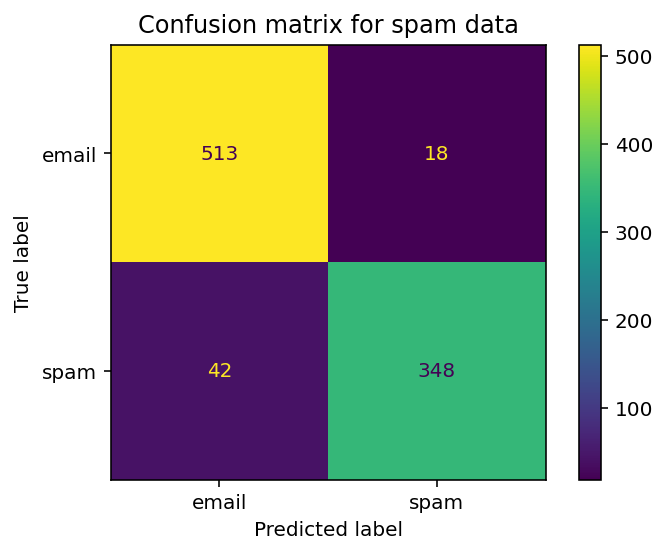

In [21]:
clf = svm.SVC(kernel='rbf') # using radial-like kernal
# train
clf.fit(X_train, y_train) 
# test
predictions = clf.predict(X_test)
# make the confusion matrix
cm = confusion_matrix(y_test,  predictions, labels=clf.classes_)
# print('clf.classes_:', clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['email','spam'])
disp.plot()
_ = plt.title('Confusion matrix for spam data')

tn, fp = cm[0]
fn, tp = cm[1]
sensitivity = tp / (tp + fn)
print('sensitivity = %0.4f' % sensitivity)
specificity = tn / (tn + fp)
print('specificity = %0.4f' % specificity)

For the SVM model, sensitivity is 89.2% and specificity is 96.6%.
The tree model in section 9.2.5 had sensitivity 86.3 % and specificity is 93.4%.

The SVM model outperformed the tree model, however, the tree model may be more interpretable. The SVM has decision boundaries in a space with 57 dimensions. Properly viewing and understanding these boundaries may be infeasible while the tree model can be interpreted as  a set of rules (such as in Figure 9.5),  to help us understand which email characteristics are  more likely to contribute to the classification of spam.

However, further work could use clustering or other feature selection tools to reduce the 57 dimensions to a lower dimensional space, and plot the decision boundaries of the SVM model with 2 features at a time. This would help with SVM model interpretability.


#### Neural Net

There are a variety of neural network architecture that could be fit for this problem.

For a better neural network model, I would re-partition the data into train, validation, and test sets, and then use cross-validation to find the best model architecture.

But the problem did not ask for that. 
So instead, I will model this neural network off of the example in the book [H], section 11.5 (see figure 11.4) and use a neural network with:
- 1 hidden layer
- 10 units in the hidden layer
- L2 regularization for weights, with weight decay parameter of 0.02.

/Users/aberke/MIT-classes/mit-stats-15.077/env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


sensitivity = 0.9103
specificity = 0.9699


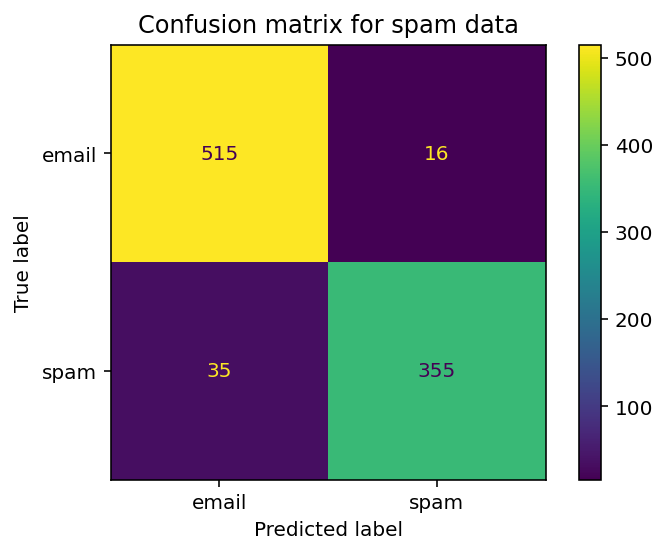

In [30]:
# According to documentation, for small datasets ‘lbfgs’ can converge faster
# and perform better. However, it was failing to allow the network to converge.
# Using default 'adam' solver instead. (Still get convergence warning, but better results).
clf = neural_network.MLPClassifier(solver='adam', # solver='lbfgs', 
                                   alpha=0.02,
                                   hidden_layer_sizes=(10),
                                   random_state=1)
# train
clf.fit(X_train, y_train) 
# test
predictions = clf.predict(X_test)
# make the confusion matrix
cm = confusion_matrix(y_test,  predictions, labels=clf.classes_)
# print('clf.classes_:', clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['email','spam'])
disp.plot()
_ = plt.title('Confusion matrix for spam data')

tn, fp = cm[0]
fn, tp = cm[1]
sensitivity = tp / (tp + fn)
print('sensitivity = %0.4f' % sensitivity)
specificity = tn / (tn + fp)
print('specificity = %0.4f' % specificity)

The neural network performs the best in terms of sensitivity and specificity. However, it is the least interpretable of the models given that it learns nonlinear functions in order to make the predictions.

Of all the models, the sensitivity and specificy scores were similar. However, for this particular problem of detecting spam, specificty seems very important, as it is problematic when good emails go to the spam folder.

For this reason, we might use the SVM classifier and do more work to make it more interpretable.

### 2. An equities analyst is studying the pharmaceutical industry and would like your help in exploring and understanding the financial data collected by her firm.  
Her main objective is to understand the structure of the pharmaceutical industry using some basic financial measures.
Financial data gathered on 21 firms in the pharmaceutical industry are available in the file
posted.  

1.
Market capitalization (in billions of dollars)

2.
Beta

3.
Price/earnings ratio

4.
Return on equity

5.
Return on assets

6.
Asset turnover

7.
Leverage

8.
Estimated revenue growth

9.
Net profit margin

10.
Median recommendation (across major brokerages)

11.
Location of firm’s headquarters

12.
Stock exchange on which the firm is listed


In [33]:
firms = pd.read_excel('pharmaceuticals.xls').set_index('Symbol')
firms

,Name,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin,Median_Recommendation,Location,Exchange
Symbol,,,,,,,,,,,,,
ABT,Abbott Laboratories,68.44,0.32,24.7,26.4,11.8,0.7,0.42,7.54,16.1,Moderate Buy,US,NYSE
AGN,"Allergan, Inc.",7.58,0.41,82.5,12.9,5.5,0.9,0.60,9.16,5.5,Moderate Buy,CANADA,NYSE
AHM,Amersham plc,6.30,0.46,20.7,14.9,7.8,0.9,0.27,7.05,11.2,Strong Buy,UK,NYSE
AZN,AstraZeneca PLC,67.63,0.52,21.5,27.4,15.4,0.9,0.00,15.00,18.0,Moderate Sell,UK,NYSE
AVE,Aventis,47.16,0.32,20.1,21.8,7.5,0.6,0.34,26.81,12.9,Moderate Buy,FRANCE,NYSE
BAY,Bayer AG,16.90,1.11,27.9,3.9,1.4,0.6,0.00,-3.17,2.6,Hold,GERMANY,NYSE
BMY,Bristol-Myers Squibb Company,51.33,0.50,13.9,34.8,15.1,0.9,0.57,2.70,20.6,Moderate Sell,US,NYSE
CHTT,"Chattem, Inc",0.41,0.85,26.0,24.1,4.3,0.6,3.51,6.38,7.5,Moderate Buy,US,NASDAQ
ELN,"Elan Corporation, plc",0.78,1.08,3.6,15.1,5.1,0.3,1.07,34.21,13.3,Moderate Sell,IRELAND,NYSE


Use cluster analysis to explore and analyze the given dataset as follows:

#### (a) Use only the quantitative variables (1 to 9) to cluster the 21 firms.  Justify the various choices made in conducting the cluster analysis, such as weights accorded different variables, the specific clustering algorithm/s used, the number of clusters formed, and so on.

The analyst is interested in understanding the structure of the data and does not have an idea for how many clusters naturally occur. For this reason we choose hierarchical clustering as a first step to better understand the structure of the data.

- Before clustering, we standardize / scale the variables to have sensible distance comparisons.
- We use euclidean distance as the distance metric.
- For the clustering method, we use “ward”. Ward recursively merges the pair of clusters that minimally increases within-cluster variance


In [43]:
quant_vars = firms.columns[1:10]
# scale the quantitative variables data
X_scaled_vars = StandardScaler().fit_transform(firms[quant_vars])
X_quant_scaled_firms = pd.DataFrame(X_scaled_vars, index=firms.index, columns=quant_vars)
X_quant_scaled_firms

,Market_Cap,Beta,PE_Ratio,ROE,ROA,Asset_Turnover,Leverage,Rev_Growth,Net_Profit_Margin
Symbol,,,,,,,,,
ABT,0.188642,-0.821041,-0.047867,0.041080,0.247579,-5.247542e-16,-0.217336,-0.540801,0.063205
AGN,-0.875518,-0.461835,3.583430,-0.875950,-0.965557,9.453132e-01,0.018736,-0.390551,-1.592035
AHM,-0.897899,-0.262277,-0.299168,-0.740094,-0.522666,9.453132e-01,-0.414062,-0.586247,-0.701953
AZN,0.174479,-0.022807,-0.248907,0.109009,0.940799,9.453132e-01,-0.768169,0.151089,0.359900
AVE,-0.183447,-0.821041,-0.336863,-0.271389,-0.580435,-4.726566e-01,-0.322256,1.246425,-0.436490
BAY,-0.712554,2.331983,0.153174,-1.487304,-1.755058,-4.726566e-01,-0.768169,-1.534116,-2.044884
BMY,-0.110533,-0.102630,-0.726379,0.611677,0.883031,9.453132e-01,-0.020609,-0.989694,0.765902
CHTT,-1.000888,1.294279,0.033806,-0.115154,-1.196630,-4.726566e-01,3.835226,-0.648387,-1.279725
ELN,-0.994419,2.212248,-1.373478,-0.726508,-1.042581,-1.890626e+00,0.635145,1.932750,-0.374028


In [56]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0,
                                linkage='ward',
                                affinity='euclidean',
                                n_clusters=None
).fit(X_quant_scaled_firms)

In [57]:
# code borrowed from 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

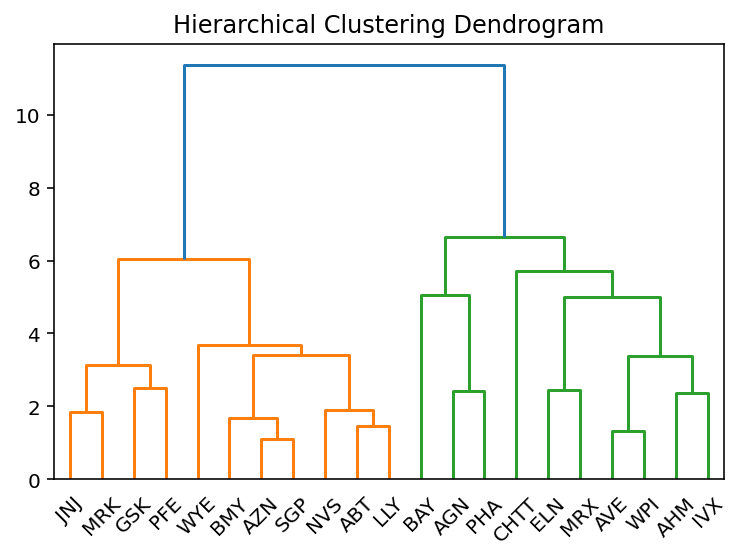

In [59]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, labels=X_quant_scaled_firms.index, truncate_mode=None)

#### 3 clusters
From the dendrogram, there seem to emerge 3 clusters.

In [62]:
model_clustering3 = AgglomerativeClustering(
                                linkage='ward',
                                affinity='euclidean',
                                n_clusters=3,
).fit(X_quant_scaled_firms)
model_clustering3

AgglomerativeClustering(n_clusters=3)

In [97]:
CLUSTER_LABEL = 'cluster label'
X_quant_scaled_firms[CLUSTER_LABEL] = model_clustering3.labels_
firms[CLUSTER_LABEL] = model_clustering3.labels_
for label in range(3):
    cluster = firms[firms[CLUSTER_LABEL] == label]
    print('\n')
    print(cluster['Name'].rename('cluster %s companies' % label))



Symbol
ABT             Abbott Laboratories
AZN                 AstraZeneca PLC
BMY    Bristol-Myers Squibb Company
LLY           Eli Lilly and Company
GSK             GlaxoSmithKline plc
JNJ               Johnson & Johnson
MRK               Merck & Co., Inc.
NVS                     Novartis AG
PFE                      Pfizer Inc
SGP     Schering-Plough Corporation
WYE                           Wyeth
Name: cluster 0 companies, dtype: object


Symbol
AHM                           Amersham plc
AVE                                Aventis
CHTT                          Chattem, Inc
ELN                  Elan Corporation, plc
IVX                       IVAX Corporation
MRX     Medicis Pharmaceutical Corporation
WPI           Watson Pharmaceuticals, Inc.
Name: cluster 1 companies, dtype: object


Symbol
AGN           Allergan, Inc.
BAY                 Bayer AG
PHA    Pharmacia Corporation
Name: cluster 2 companies, dtype: object


#### (b) Interpret the clusters with respect to the quantitative variables that were used in forming the clusters.

Below are boxplots for the quantitative variables by cluster (where the values are standardized).

Cluster 0:
- highest values for Market cap, asset turnover, Return on assets, Net profit margin
- perhaps these are the market leaders

Cluster 1:
- These companies have the highest revenue growth and leverage. 
- low asset turnover (except for an outlier)
- Perhaps these are newly successful companies.

Cluster 2:
- highest and most variable Price/Earnings ratio
- otherwise this cluster does not stand out.

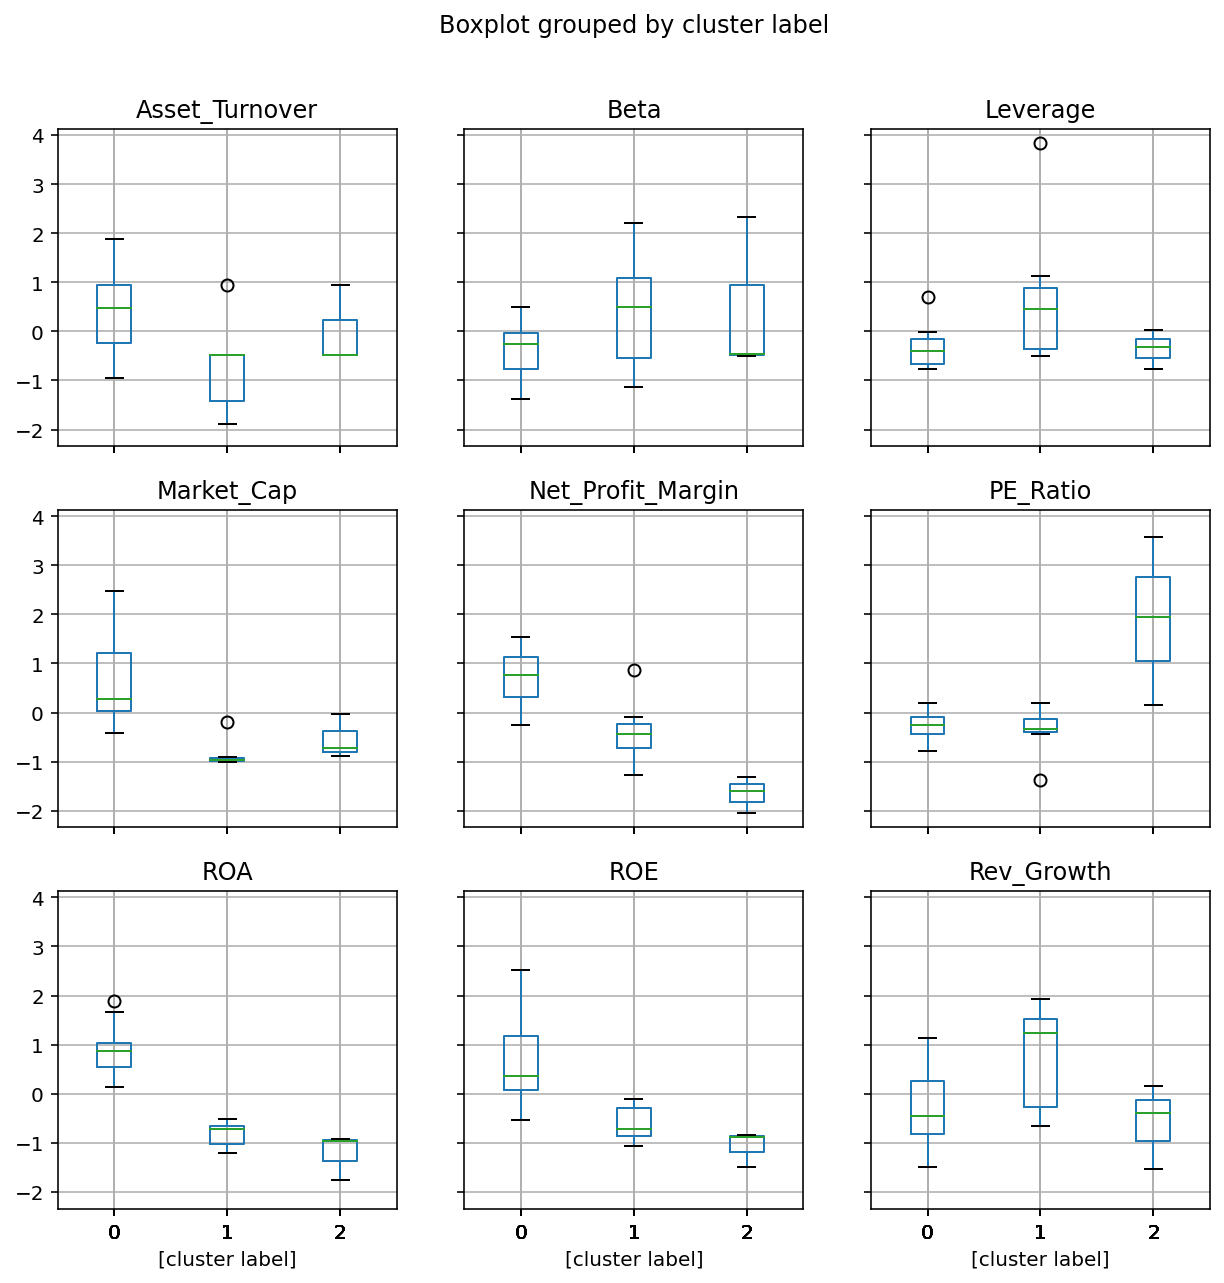

In [102]:
fig, ax = plt.subplots(1, figsize=(10,10))
title = 'Quantitative variables by cluster (values scaled)'
axes = X_quant_scaled_firms.boxplot(by=CLUSTER_LABEL, ax=ax)
ax.set_title(title)
_ = plt.show()

#### (c) Is there a pattern in the clusters with respect to the qualitative variables (10 to 12) (those not used in forming the clusters)?

Median Recommendation:
Cluster 0 companies are companies to "Hold" while cluster 1 companies are more often companies to buy.


Location: 
All the companies tend to be in the U.S. but there is a more even distribution of locations in cluster 2.

In [104]:
qual_vars = firms.columns[10:12]
qual_vars

Index(['Median_Recommendation', 'Location'], dtype='object')

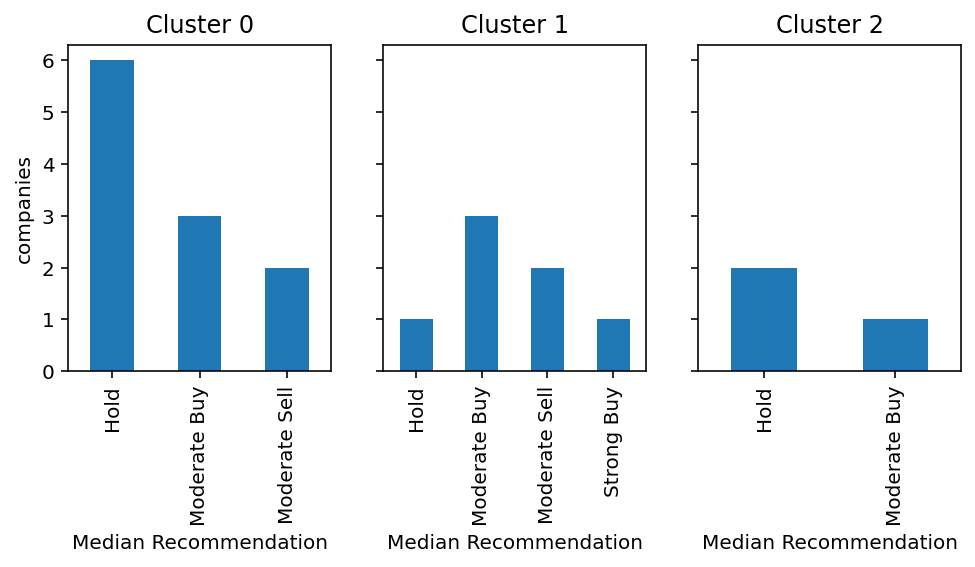

cluster label  Median_Recommendation
0              Hold                     6
               Moderate Buy             3
               Moderate Sell            2
1              Hold                     1
               Moderate Buy             3
               Moderate Sell            2
               Strong Buy               1
2              Hold                     2
               Moderate Buy             1
Name: Name, dtype: int64

In [141]:
cluster_recs = firms.groupby([CLUSTER_LABEL, 'Median_Recommendation']).count()['Name']
fig, axes = plt.subplots(1,3, figsize=(8,3), sharey=True)
for i, ax in enumerate(axes):
    ax.set_title('Cluster %s' % i)
    cluster_recs.loc[i].plot.bar(ax=ax)
    ax.set_ylabel('companies')
    ax.set_xlabel('Median Recommendation')
plt.show()
cluster_recs

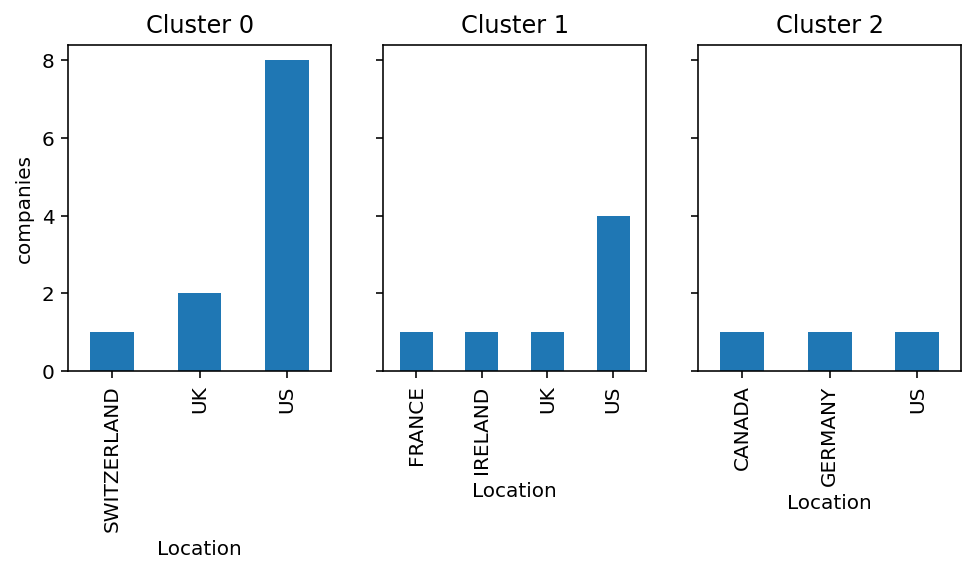

cluster label  Location   
0              SWITZERLAND    1
               UK             2
               US             8
1              FRANCE         1
               IRELAND        1
               UK             1
               US             4
2              CANADA         1
               GERMANY        1
               US             1
Name: Name, dtype: int64

In [142]:
cluster_locations = firms.groupby([CLUSTER_LABEL, 'Location']).count()['Name']
fig, axes = plt.subplots(1,3, figsize=(8,3), sharey=True)
for i, ax in enumerate(axes):
    ax.set_title('Cluster %s' % i)
    cluster_locations.loc[i].plot.bar(ax=ax)
    ax.set_ylabel('companies')
plt.show()
cluster_locations

#### (d) Provide an appropriate name for each cluster using any or all of the variables in the dataset.

Based on the evaluation of variables for the clusters in (b) and (c):

- cluster 0: market leaders
- cluster 1: growing companies
- cluster 2: high PE